<a href="https://colab.research.google.com/github/armleth/mlvc/blob/main/EDSR_shared_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhanced Deep Residual Networks for single-image super-resolution



## Introduction

Ceci est un test.

In this example, we implement
[Enhanced Deep Residual Networks for Single Image Super-Resolution (EDSR)](https://arxiv.org/abs/1707.02921)
by Bee Lim, Sanghyun Son, Heewon Kim, Seungjun Nah, and Kyoung Mu Lee.

The EDSR architecture is based on the SRResNet architecture and consists of multiple
residual blocks. It uses constant scaling layers instead of batch normalization layers to
produce consistent results (input and output have similar distributions, thus
normalizing intermediate features may not be desirable). Instead of using a L2 loss (mean squared error),
the authors employed an L1 loss (mean absolute error), which performs better empirically.

Our implementation only includes 16 residual blocks with 64 channels.

Alternatively, as shown in the Keras example
[Image Super-Resolution using an Efficient Sub-Pixel CNN](https://keras.io/examples/vision/super_resolution_sub_pixel/#image-superresolution-using-an-efficient-subpixel-cnn),
you can do super-resolution using an ESPCN Model. According to the survey paper, EDSR is one of the top-five
best-performing super-resolution methods based on PSNR scores. However, it has more
parameters and requires more computational power than other approaches.
It has a PSNR value (≈34db) that is slightly higher than ESPCN (≈32db).
As per the survey paper, EDSR performs better than ESPCN.

Comparison Graph:
<img src="https://dfzljdn9uc3pi.cloudfront.net/2021/cs-621/1/fig-11-2x.jpg" width="500" />

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

import pickle
import os

AUTOTUNE = tf.data.AUTOTUNE

2025-11-05 22:39:09.413873: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 22:39:09.430571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 22:39:11.880812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Download the training dataset

We use the DIV2K Dataset, a prominent single-image super-resolution dataset with 1,000
images of scenes with various sorts of degradations,
divided into 800 images for training, 100 images for validation, and 100
images for testing. We use 4x bicubic downsampled images as our "low quality" reference.

In [2]:
# Train data : load (or Download if first usage) DIV2K from TF Datasets
train = tfds.load("div2k/bicubic_x4", split="train", as_supervised=True)
train_cache = train.cache()

# Validation data : load (or Download if first usage) DIV2K from TF Datasets
val = tfds.load("div2k/bicubic_x4", split="validation", as_supervised=True)
val_cache = val.cache()

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/armleth/tensorflow_datasets/div2k/bicubic_x4/incomplete.CG35F9_2.0.0/div2k-train.tfrecord*...:…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/armleth/tensorflow_datasets/div2k/bicubic_x4/incomplete.CG35F9_2.0.0/div2k-validation.tfrecord…

Dataset div2k downloaded and prepared to /home/armleth/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


## Flip, crop and resize images

In [3]:

def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped


## Prepare a `tf.data.Dataset` object

We augment the training data with random horizontal flips and 90 rotations.

As low resolution images, we use 24x24 RGB input patches.

In [4]:

def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

## Visualize the data

Let's visualize a few sample images:

2025-11-03 16:39:26.065988: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


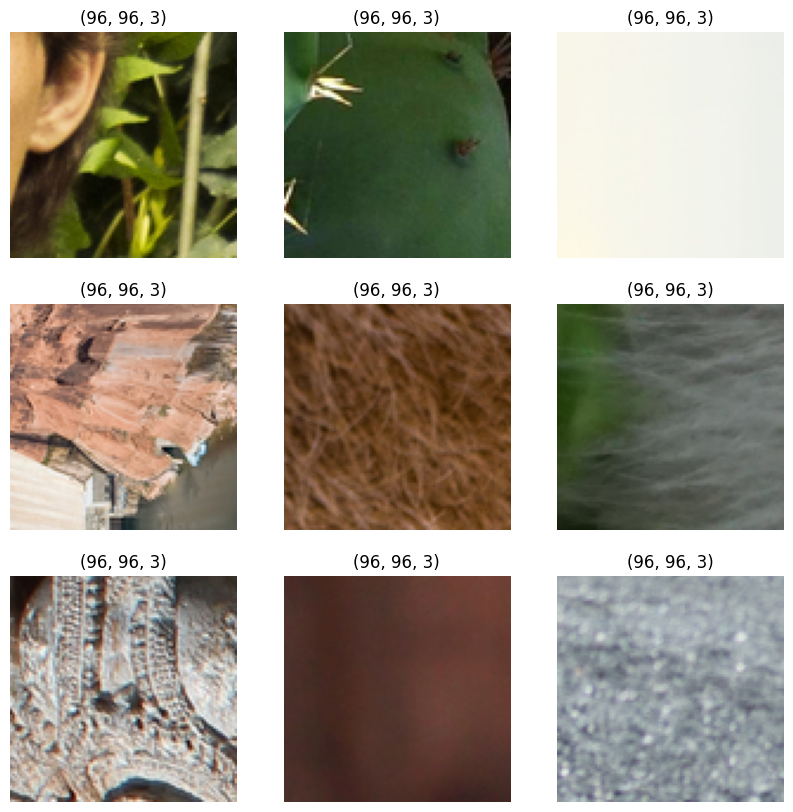

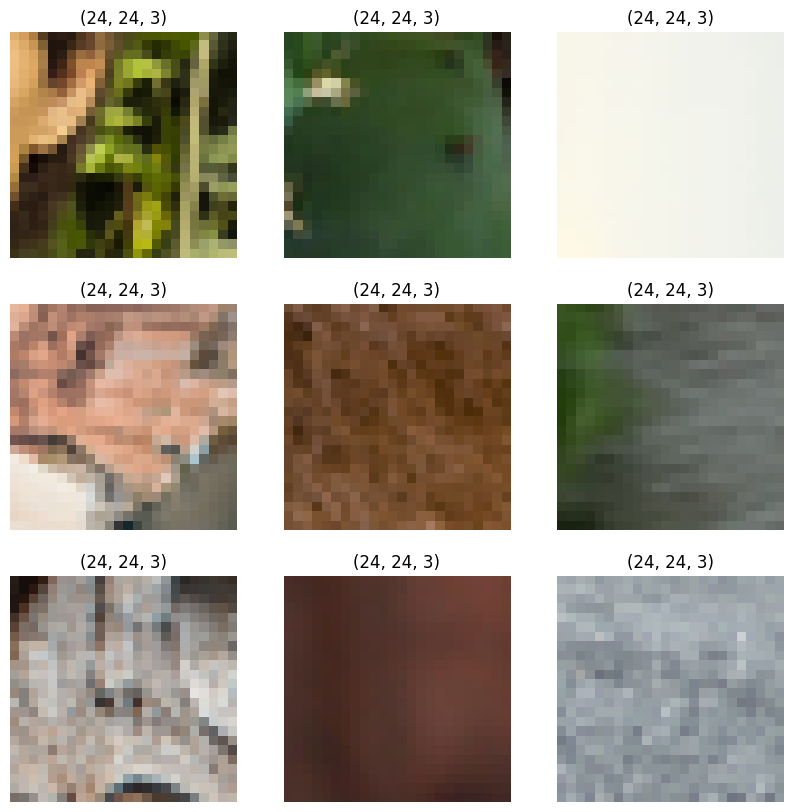

In [5]:
lowres, highres = next(iter(train_ds))

# High Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


# Loss function (PSNR)


In [6]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

def PSNR_non_training(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)
    return tf.get_static_value(psnr_value)

## Build the model

In the paper, the authors train three models: EDSR, MDSR, and a baseline model. In this code example,
we only train the baseline model.

### Comparison with model with three residual blocks

The residual block design of EDSR differs from that of ResNet. Batch normalization
layers have been removed (together with the final ReLU activation): since batch normalization
layers normalize the features, they hurt output value range flexibility.
It is thus better to remove them. Further, it also helps reduce the
amount of GPU RAM required by the model, since the batch normalization layers consume the same amount of
memory as the preceding convolutional layers.

<img src="https://miro.medium.com/max/1050/1*EPviXGqlGWotVtV2gqVvNg.png" width="500" />

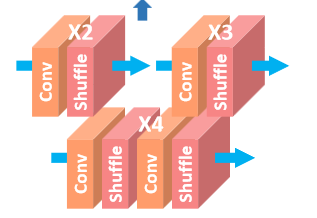

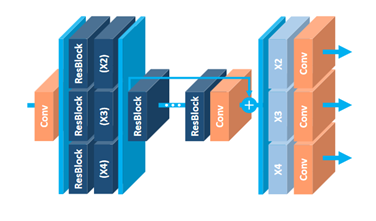

In [7]:

class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(inputs)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, block_size=factor))(x)
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, block_size=factor))(x)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

## Train the model or load weights if already trained

In [8]:
# True : first execution
# False : from second execution to avoid re training
retrain = False
epochs  = 10
weights_filename = 'weights_psnr_' + str(epochs) + 'epochs.weights.h5'
model = make_model(num_filters=64, num_of_residual_blocks=16)

# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])

if(retrain):
    # Training for more epochs will improve results
    model.fit(train_ds, epochs=epochs, steps_per_epoch=200, validation_data=val_ds)
    model.save_weights(weights_filename)
else:
    model.load_weights(weights_filename)

/Users/toutane/epita/scia/mlvc/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 149 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Run inference on new images and plot the results

In [13]:

def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(12, 7))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()


for lowres, highres in val.take(1):
    print(type(lowres))
    print(lowres.shape)
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    print(lowres.shape)
    preds = model.predict_step(lowres)
    #plot_results(lowres, preds)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(510, 417, 3)
(150, 150, 3)


(1080, 1920, 3)
(135, 240, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(96, 96, 3)


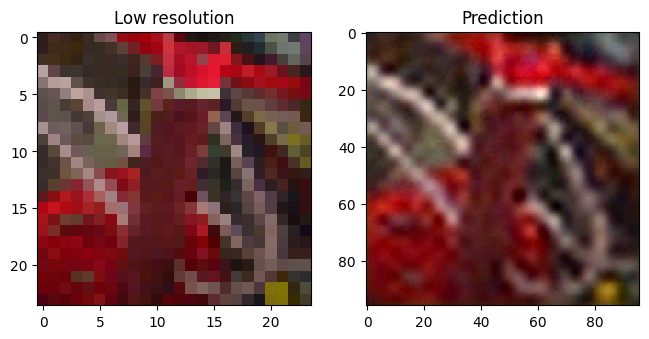

13.745729


In [24]:
from PIL import Image
highres_image = Image.open("/Users/toutane/Downloads/TP material/source/converted/PNGs/frame_0000.png")
highres_array = np.array(highres_image)
print(highres_array.shape)
scale = 8
lowres_shape = [highres_array.shape[0] // scale, highres_array.shape[1] // scale]
lowres_image = tf.image.resize(highres_image, lowres_shape)
print(lowres_image.shape)

lr, hr = random_crop(lowres_image, highres_array)

preds = model.predict(lr)
print(preds.shape)
plot_results(lr / 255.0, preds)

print(PSNR_non_training(preds, hr))

In [67]:
from PIL import Image

def super_resolve_image(file_path, save_dir, model, scale=1):
    highres_image = Image.open(file_path).convert("RGB")
    highres_array = np.array(highres_image)

    lowres_shape = [highres_array.shape[0] // scale, highres_array.shape[1] // scale]
    lowres_tensor = tf.image.resize(highres_array, lowres_shape, method="bicubic")

    preds = model.predict(lowres_tensor)
    pred_image = Image.fromarray(preds)

    base, ext = os.path.splitext(file_path)
    name = base.split('/')[-1]
    save_path = f"{save_dir}/{name}_upscaled{ext}"
    pred_image.save(save_path)
    print(f"Saved enhanced image to: {save_path}")

    #plot_results(lowres_tensor / 255.0, preds)
    #print("PSNR:", PSNR_non_training(preds, highres_array))
    
    return save_path

In [72]:
directory = "/Users/toutane/Downloads/TP material/source/converted/PNGs"
save_dir = "/Users/toutane/Downloads/TP material/source/converted/PNGs/upscaled"

try:
    os.mkdir(save_dir)
except OSError as e:
    print(e)


for file in os.listdir(directory):
    if (os.path.splitext(file)[1] != '.png'):
        continue
    super_resolve_image(directory + '/' + file, save_dir, model)

[Errno 17] File exists: '/Users/toutane/Downloads/TP material/source/converted/PNGs/upscaled'
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step
Saved enhanced image to: /Users/toutane/Downloads/TP material/source/converted/PNGs/upscaled/frame_0028_upscaled.png
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step
Saved enhanced image to: /Users/toutane/Downloads/TP material/source/converted/PNGs/upscaled/frame_0000_upscaled.png
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 314ms/step
Saved enhanced image to: /Users/toutane/Downloads/TP material/source/converted/PNGs/upscaled/frame_0014_upscaled.png
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step
Saved enhanced image to: /Users/toutane/Downloads/TP material/source/converted/PNGs/upscaled/frame_0015_upscaled.png
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step
Saved enhanced image to: /Users/toutane/Downloads/TP material/source/converted/PNGs/upscaled/frame_0001_upscaled.png
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step
Saved enhanced image to: /Users/toutane/Downloads/TP material/source/

#Conversion YUV <-> PNG for video processing

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image

def yuv420_to_png(yuv_file, width, height, num_frames, output_dir_png):
    # Check if the directory exists
    if os.path.exists(output_dir_png):
        # If it exists, delete it
        shutil.rmtree(output_dir_png)
        print(f"Created directory {output_dir_png}")

    # Create a new directory
    os.makedirs(output_dir_png)

    # Open the YUV file
    with open(yuv_file, "rb") as file:
        frame_size = width * height * 3 // 2  # YUV420p has 1.5 bytes per pixel

        for i in range(num_frames):
            # Read the Y, U, and V components
            y = np.frombuffer(file.read(width * height), dtype=np.uint8).reshape((height, width))
            u = np.frombuffer(file.read(width * height // 4), dtype=np.uint8).reshape((height // 2, width // 2))
            v = np.frombuffer(file.read(width * height // 4), dtype=np.uint8).reshape((height // 2, width // 2))

            # Upsample U and V to match the Y plane size
            u_up = u.repeat(2, axis=0).repeat(2, axis=1)
            v_up = v.repeat(2, axis=0).repeat(2, axis=1)

            # Combine Y, U, V into an RGB image
            yuv = np.stack((y, u_up, v_up), axis=-1)
            rgb = Image.fromarray(yuv, "YCbCr").convert("RGB")

            # Save the frame as a PNG file
            png_filename = os.path.join(output_dir_png, f"frame_{i:04d}.png")
            rgb.save(png_filename)


def png_to_yuv420(input_dir, num_frames):
    # Directory path for the output
    output_dir = os.path.join(os.path.dirname(input_dir), "YUV")

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f'Directory {output_dir} created.')

    # Get the list of PNG files, sorted by frame order
    png_files = sorted([f for f in os.listdir(input_dir) if f.endswith('.png')])[:num_frames]

    # Determine the size of the images
    sample_image = Image.open(os.path.join(input_dir, png_files[0]))
    width, height = sample_image.size

    # Open a YUV file to write the frames into
    yuv_filename = os.path.join(output_dir, f"output_{width}x{height}_{num_frames}_420.yuv")
    with open(yuv_filename, "wb") as yuv_file:
        for i, png_file in enumerate(png_files):
            img = Image.open(os.path.join(input_dir, png_file)).convert("YCbCr")
            y, u, v = img.split()

            # Downsample U and V to 1/4 resolution
            u = u.resize((width // 2, height // 2), Image.Resampling.NEAREST)
            v = v.resize((width // 2, height // 2), Image.Resampling.NEAREST)

            # Write Y, U, and V planes to the YUV file
            yuv_file.write(y.tobytes())
            yuv_file.write(u.tobytes())
            yuv_file.write(v.tobytes())
            print(f'File {i} done')
        print(f'YUV stored at {output_dir}')

## Final remarks

In this example, we implemented the EDSR model (Enhanced Deep Residual Networks for Single Image
Super-Resolution). You could improve the model accuracy by training the model for more epochs, as well as
training the model with a wider variety of inputs with mixed downgrading factors, so as to
be able to handle a greater range of real-world images.

You could also improve on the given baseline EDSR model by implementing EDSR+,
or MDSR( Multi-Scale super-resolution) and MDSR+,
which were proposed in the same paper.

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Model-EDSR-red.svg)](https://huggingface.co/keras-io/EDSR) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-EDSR-red.svg)](https://huggingface.co/spaces/keras-io/EDSR) |